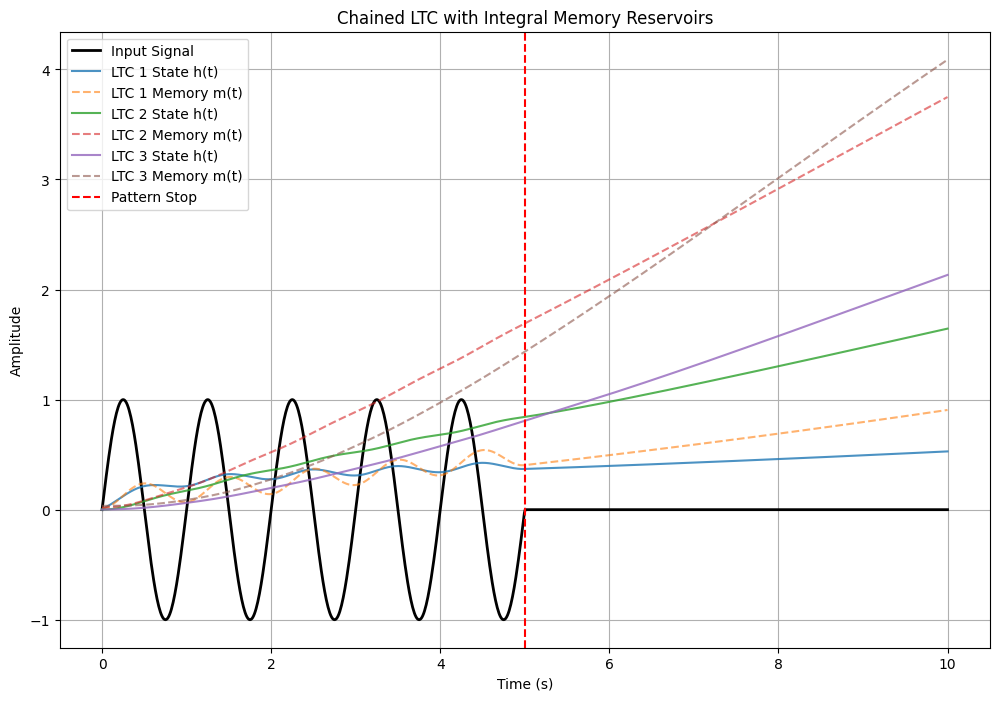

LTC 1 retains memory beyond simulation time.
LTC 2 retains memory beyond simulation time.
LTC 3 retains memory beyond simulation time.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# ----- PARAMETERS -----
num_ltc         = 3       # Number of LTC neurons in chain
tau             = 1.0     # LTC time constant
gleak           = 0.5     # Leak conductance
cm_t            = 1.0     # Membrane capacitance for LTC
gamma           = 0.01    # Memory reservoir decay
lambda_m        = 0.5     # Strength of memory feedback into state
dt              = 0.01    # Time step
total_time      = 10.0    # Total simulation time
pattern_time    = 5.0     # Duration of feeding pattern
h_threshold     = 0.05    # Threshold for forgetting in h
m_threshold     = 0.03    # Threshold for forgetting in m

num_steps       = int(total_time / dt)
pattern_steps   = int(pattern_time / dt)

# ----- TIME & INPUT SIGNAL -----
t = np.linspace(0, total_time, num_steps)
freq = 1.0
input_signal = np.zeros(num_steps)
for i in range(pattern_steps):
    input_signal[i] = np.sin(2 * np.pi * freq * t[i])

# Example kernel for memory accumulation
def memory_kernel(h_val):
    alpha = 0.5  # or tune this parameter
    return np.exp(-alpha * abs(h_val))

# Example function for actual "input" we want to store
# Here, let's accumulate the external input signal or a mix
def memory_input(u_val, h_val, mix=0.5):
    # Weighted blend of external input + some function of the state
    return (1 - mix) * u_val + mix * h_val

# Sigmoid for bounding neuron input
def sigmoid(x, mu=0.5, sigma=1.0):
    return 1 / (1 + np.exp(-sigma * (x - mu)))

# ----- INITIALIZE STATES -----
h_vals = np.zeros((num_ltc, num_steps))  # LTC states over time
m_vals = np.zeros((num_ltc, num_steps))  # Memory states over time

h = np.zeros(num_ltc)  # current LTC states
m = np.random.uniform(0.01, 0.1, num_ltc)  # non-zero initial memory

# Random weights for the LTC chain
weights = np.random.uniform(0.5, 1.5, num_ltc)

# ----- SIMULATION -----
for i in range(num_steps):
    # Neuron 0 gets external input
    u0 = sigmoid(input_signal[i])
    
    # LTC State Derivative (Neuron 0)
    dh0 = (1.0/tau)*(u0 - h[0]) - gleak*h[0] + lambda_m*m[0]
    h[0] += (dh0 / cm_t)*dt
    
    # Memory Reservoir Derivative (Neuron 0)
    # We accumulate both the external input and some fraction of the neuron's own state
    I0 = memory_input(input_signal[i], h[0], mix=0.3)
    dm0 = I0*memory_kernel(h[0]) - gamma*m[0]
    m[0] += dm0*dt
    
    # Update subsequent neurons in chain
    for j in range(1, num_ltc):
        # LTC State Derivative
        dh = (1.0/tau)*(weights[j-1]*h[j-1] - h[j]) - gleak*h[j] + lambda_m*m[j]
        h[j] += (dh / cm_t)*dt
        
        # Memory Reservoir Derivative
        # accumulates partial external + partial LTC state or feed from the prior memory
        Ij = memory_input(weights[j-1]*h[j-1], h[j], mix=0.3)
        dm = Ij*memory_kernel(h[j]) - gamma*m[j]
        m[j] += dm*dt
    
    # Store states
    h_vals[:, i] = h
    m_vals[:, i] = m

# ----- PLOTTING -----
plt.figure(figsize=(12, 8))
plt.plot(t, input_signal, label='Input Signal', linewidth=2, color='k')
for i in range(num_ltc):
    plt.plot(t, h_vals[i], label=f'LTC {i+1} State h(t)', alpha=0.8)
    plt.plot(t, m_vals[i], '--', label=f'LTC {i+1} Memory m(t)', alpha=0.6)
plt.axvline(pattern_time, color='r', linestyle='--', label='Pattern Stop')
plt.title("Chained LTC with Integral Memory Reservoirs")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend(loc='best')
plt.show()

# ----- FORGETTING CHECK -----
for i in range(num_ltc):
    forget_time = None
    for idx in range(pattern_steps, num_steps):
        avg_val = (abs(h_vals[i, idx]) + abs(m_vals[i, idx])) / 2.0
        if avg_val < max(h_threshold, m_threshold):
            forget_time = t[idx] - pattern_time
            break
    if forget_time is not None:
        print(f"LTC {i+1} forgets at ~{forget_time:.2f}s after pattern stops.")
    else:
        print(f"LTC {i+1} retains memory beyond simulation time.")